In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
numeric_df = pd.read_csv("../data/items_processed.csv")
numeric_df.head()

,num_images,mileage,price,date_idx,category_app,category_art,category_atq,category_avo,category_bab,category_bfd,...,location_woonsocket,"location_woonsocket ,r.i.",location_woonsocket ri,"location_woonsocket, ri",location_ww/ coventry,location_ww/cov,location_ww/coventry,location_www.smdwoods.com,location_wyoming,"location_🇺🇸#piano mover and tuning ..ri,ma.,ct, insured!"
0,1,0.0,5.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0.0,4.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0.0,7.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0.0,3.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0.0,5.0,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
with open("../data/reduced_features.npy", "rb") as image_npy:
    image_features = np.load(image_npy)
# with open("../data/res_image_features.npy", "rb") as image_npy:
#     image_features = np.load(image_npy)

In [41]:
with open("../data/text_embeds.npy", "rb") as text_npy:
    text_features = np.load(text_npy)

In [42]:
assert text_features.shape[0] == numeric_df.shape[0]

assert image_features.shape[0] == numeric_df.shape[0]
# text_features.shape[0]
# image_features.shape[0]

In [43]:
target = numeric_df["price"].values

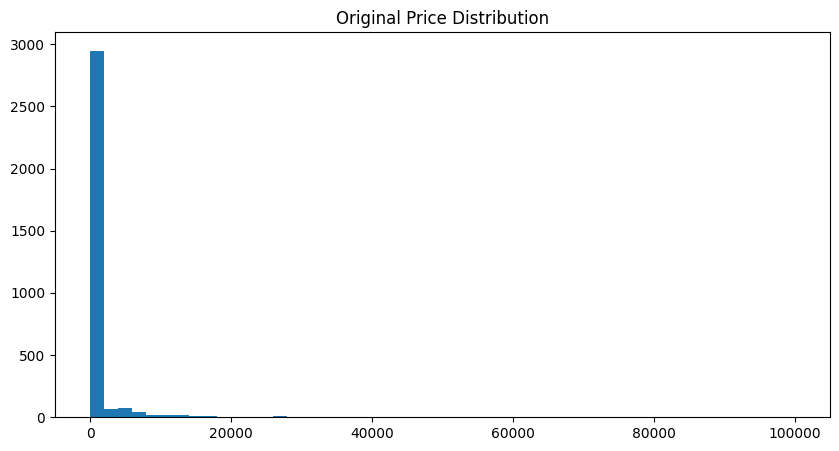

In [44]:
plt.figure(figsize=(10, 5))
plt.hist(target, bins=50)
plt.title("Original Price Distribution")
plt.show()
#it is very skewed

In [45]:
#price stats
print("Target statistics:")
print(f"Min price: ${np.min(target):,.2f}")
print(f"Max price: ${np.max(target):,.2f}")
print(f"Mean price: ${np.mean(target):,.2f}")
print(f"Median price: ${np.median(target):,.2f}")

Target statistics:
Min price: $1.00
Max price: $99,999.00
Mean price: $1,157.42
Median price: $75.00


In [46]:
numeric_values = numeric_df.drop("price", axis = 1).values

In [47]:
numeric_features = numeric_df.drop("price", axis = 1).columns

In [48]:
numeric_values.shape, text_features.shape, image_features.shape

((3253, 354), (3253, 96), (3253, 171))

In [49]:
# scaler = StandardScaler()
# numeric_scaled = scaler.fit_transform(numeric_values)
# text_scaled = scaler.fit_transform(text_features)
# image_scaled = scaler.fit_transform(image_features)

In [50]:
# all_features = np.concatenate([numeric_scaled, text_scaled, image_scaled], axis=1)
all_features = np.concatenate([numeric_values, text_features, image_features], axis=1)
all_features.shape

(3253, 621)

In [51]:
# Remove Outliers in Modeling

pct_90 = np.percentile(target, 90)
pct_10 = np.percentile(target, 10)

print(pct_10, pct_90)

mask = (pct_10 <= target) & (target <= pct_90)

all_features = all_features[mask]
target = target[mask]

10.0 1740.000000000009


In [52]:
all_features.shape

(2698, 621)

In [53]:
### Linear Regression Analysis

In [54]:
#uses linear regression
def CV_train_linear_regression(X, y, cv = 5):
    reg = LinearRegression()
    y_log = np.log1p(y)  # Log transformation to handle skewness
    # y_log = y
    
    

    cv_results = cross_validate(reg,
                                X,
                                y_log,
                                cv = KFold(
                                    n_splits = 5, 
                                    shuffle = True,
                                    random_state = 0),
                                scoring = ["neg_root_mean_squared_error", "r2"],
                                return_estimator = True)
        
    return cv_results

In [55]:
linreg_cv = CV_train_linear_regression(all_features, target)
print(f"Median RMSE: {-np.median(linreg_cv['test_neg_root_mean_squared_error'])}")
print(f"Median R2: {np.median(linreg_cv['test_r2'])}")

Median RMSE: 1.0622938726376105
Median R2: 0.2302949732648123


In [56]:
#uses non_linear regression
def CV_train_non_linear_regression(X, y, cv=5):
    reg = GradientBoostingRegressor(random_state=0)  # Use a non-linear regression model
    y_log = np.log1p(y)  # Log transformation to handle skewness

    cv_results = cross_validate(reg,
                                X,
                                y_log,
                                cv=KFold(
                                    n_splits=cv,
                                    shuffle=True,
                                    random_state=0),
                                scoring=["neg_root_mean_squared_error", "r2"],
                                return_estimator=True)
    
    return cv_results

In [57]:
non_linreg_cv = CV_train_non_linear_regression(all_features, target)
print(f"Median RMSE: {-np.median(non_linreg_cv['test_neg_root_mean_squared_error'])}")
print(f"Median R2: {np.median(non_linreg_cv['test_r2'])}")

Median RMSE: 1.010108067162944
Median R2: 0.3195387115110685


In [58]:
def train_optimized_gb(X, y, cv=5):
    # Try different hyperparameters for GradientBoosting
    optimized_gb = GradientBoostingRegressor(
        n_estimators=200,  # More trees
        learning_rate=0.1,  # Slower learning rate
        max_depth=5,       # Control tree depth
        min_samples_split=5,
        subsample=0.8,     # Use 80% of samples for each tree
        random_state=0
    )
    
    y_log = np.log1p(y)
    cv_results = cross_validate(optimized_gb,
                              X,
                              y_log,
                              cv=KFold(n_splits=cv, shuffle=True, random_state=0),
                              scoring=["neg_root_mean_squared_error", "r2"],
                              return_estimator=True)
    
    print("\nOptimized Gradient Boosting Results:")
    print(f"Median RMSE: {-np.median(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"Median R2: {np.median(cv_results['test_r2'])}")
    
    return cv_results

# Run optimized Gradient Boosting
optimized_results = train_optimized_gb(all_features, target)


Optimized Gradient Boosting Results:
Median RMSE: 0.9927955913948304
Median R2: 0.3462222391732177


In [59]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target, train_size = 0.8, shuffle = True)
print((X_train.shape, X_test.shape, y_train.shape, y_test.shape))

((2158, 621), (540, 621), (2158,), (540,))


In [60]:
linear_y_pred = linreg_cv["estimator"][-1].predict(X_test)
non_linear_y_pred = non_linreg_cv["estimator"][-1].predict(X_test)
# optimized_gb = optimized_gb_cv[["estimator"][-1].predict(X_test)]


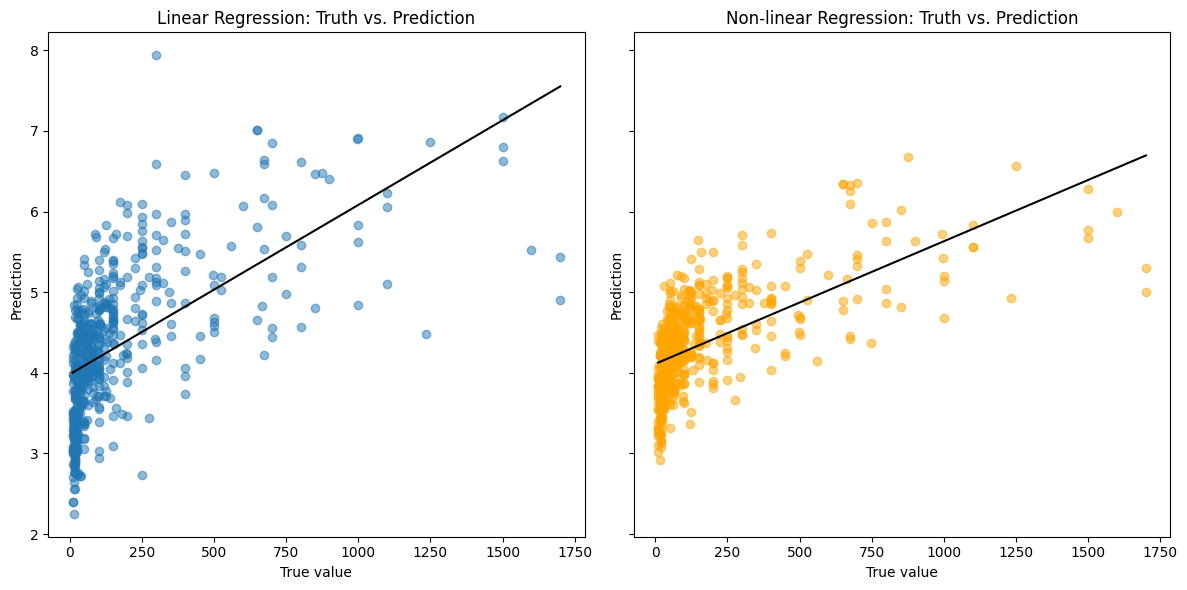

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Linear regression plot
axes[0].scatter(y_test, linear_y_pred, alpha=0.5)
axes[0].plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, linear_y_pred, 1))(np.unique(y_test)), c="black")
axes[0].set_xlabel("True value")
axes[0].set_ylabel("Prediction")
axes[0].set_title("Linear Regression: Truth vs. Prediction")

# Non-linear regression plot
axes[1].scatter(y_test, non_linear_y_pred, alpha=0.5, color="orange")
axes[1].plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, non_linear_y_pred, 1))(np.unique(y_test)), c="black")
axes[1].set_xlabel("True value")
axes[1].set_ylabel("Prediction")
axes[1].set_title("Non-linear Regression: Truth vs. Prediction")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [62]:
def label_coef(c, i):
    numeric_values.shape, text_features.shape, image_features.shape
    if i < numeric_values.shape[1]:
        return ("scraped feature", c, i, numeric_features[i])
    
    if numeric_values.shape[1] <= i < (text_features.shape[1] + numeric_values.shape[1]):
        return ("text feature", c, i, None)
    
    if i >= (text_features.shape[1] + numeric_values.shape[1]):
        return ("image feature", c, i, None)

In [63]:
coef_df = pd.DataFrame(sorted(
    [label_coef(c, i) for i, c in enumerate(abs(linreg_cv["estimator"][2].coef_))],
    key = lambda x : x[1],
    reverse = True),
    columns = ["feature source", "coef", "feature index", "feature name"])

In [64]:
coef_df = coef_df.reset_index().rename({"index": "order"}, axis = 1)

In [65]:
coef_df

,order,feature source,coef,feature index,feature name
0,0,scraped feature,9.809257e+07,6,category_avo
1,1,scraped feature,7.508865e+07,8,category_bfd
2,2,scraped feature,6.735929e+07,26,category_grq
3,3,scraped feature,6.735929e+07,28,category_hsh
4,4,scraped feature,6.735929e+07,11,category_bks
...,...,...,...,...,...
616,616,text feature,5.422249e-03,377,None
617,617,text feature,2.240008e-03,423,None
618,618,text feature,1.159925e-03,366,None
619,619,text feature,8.750148e-04,356,None


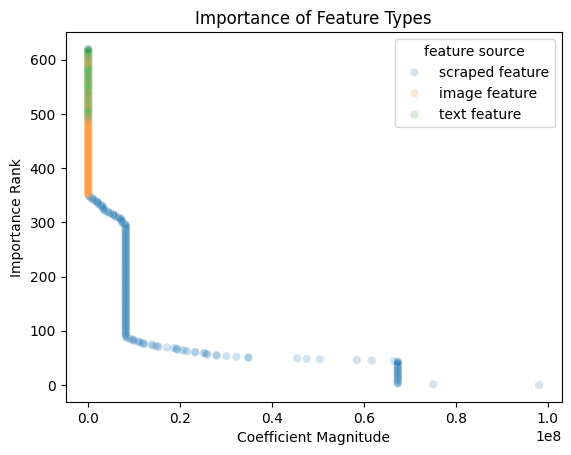

In [66]:
import seaborn as sns

sns.scatterplot(data = coef_df, x = "coef", y = "order", hue = "feature source", alpha = 0.2)
plt.title("Importance of Feature Types")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Importance Rank")
plt.savefig("../analysis_deliverable/visualizations/feature_importance.png")
pass
# coef_df[["order", "coef", "feature source"]].plot.scatter(x = "coef", y = "order", hue = "feature source")

In [67]:
### K-Means Clustering Analysis

In [68]:
def train_cluster(X, y, n_clusters = 10):
    kmeans = KMeans(n_clusters, random_state = 0)
    cluster_labels = kmeans.fit_predict(X)
    clusters = kmeans.cluster_centers_
    cluster_info = []
    for i in range(n_clusters):
        avg_cluster_price = np.mean(y[cluster_labels == i])
        num_values = sum(cluster_labels == i)
        cluster_info.append([avg_cluster_price, num_values])
    return pd.DataFrame(cluster_info, columns = ["average price in cluster", "num items in cluster"]), clusters, cluster_labels


In [69]:
cluster_df, cluster_centers, cluster_labels = train_cluster(all_features, target, 10)

In [70]:
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (All Features)')

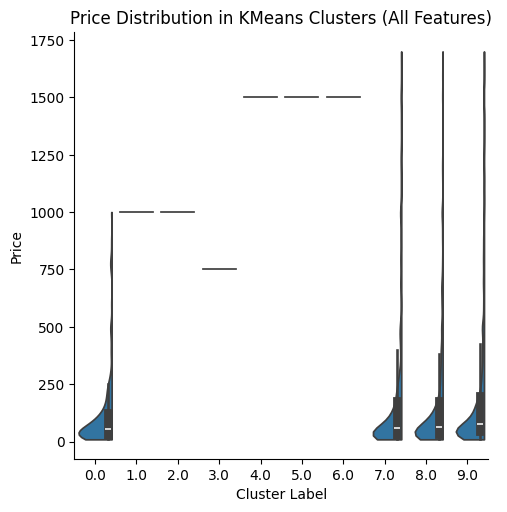

In [71]:
import seaborn as sns

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (All Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Webscraped Features)')

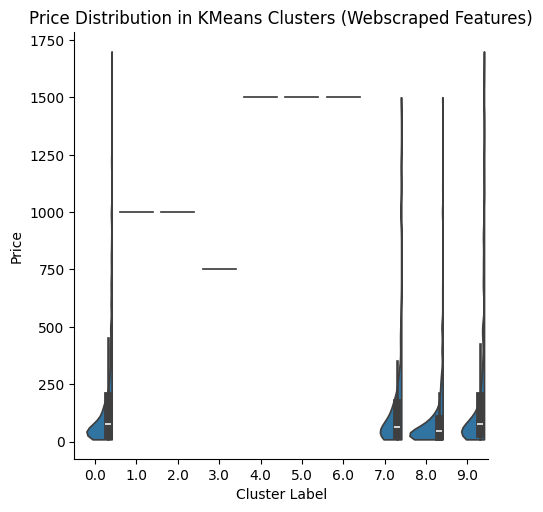

In [72]:
cluster_df, cluster_centers, cluster_labels = train_cluster(numeric_values[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Webscraped Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Image Features)')

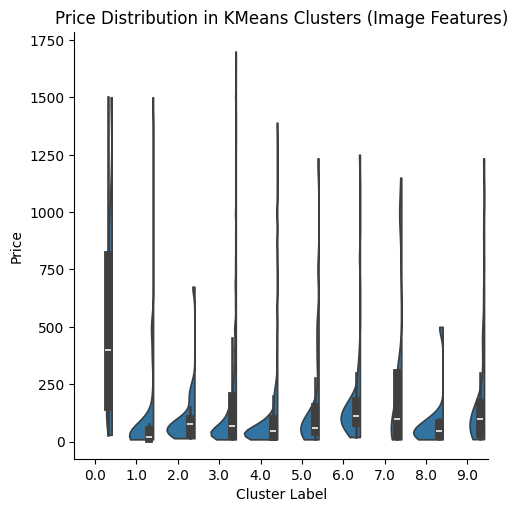

In [73]:
cluster_df, cluster_centers, cluster_labels = train_cluster(image_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Image Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Text Features)')

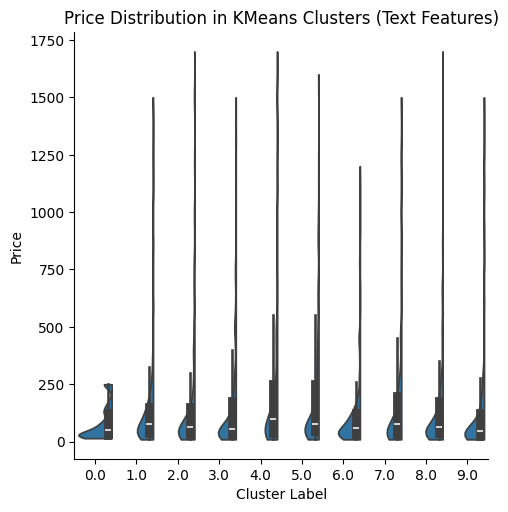

In [74]:
cluster_df, cluster_centers, cluster_labels = train_cluster(text_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Text Features)")